In [1]:
from transformers import AutoTokenizer, VisionEncoderDecoderModel, AutoImageProcessor
from PIL import Image
import requests

repo_name = "MixTex/Base_ZhEn"
feature_extractor = AutoImageProcessor.from_pretrained(repo_name)
tokenizer = AutoTokenizer.from_pretrained(repo_name, max_len=296)
model = VisionEncoderDecoderModel.from_pretrained(repo_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
model.decoder

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(30002, 768)
    (wpe): Embedding(516, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2Attention(
          (c_attn): Conv1D(nf=1536, nx=768)
          (q_attn): Conv1D(nf=768, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv

In [6]:
model.config

VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "gpt2_base",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "initializer_range": 0.02,
    "is_decoder": true,
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 6,
    "n_positions": 516,
    "reorder_and_upcast_attn": false,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "summary_proj_to_labels": true,
    "summary_type": "cls_index",
    "summary_use_proj": true,
    "torch_dtype": "float32",
    "type_vocab_size": 1,
    "use_cache": true,
    "vocab_size": 30002
  },
  "decoder_start_token_id": 0,
  "encoder": {
    "_name_or_path"

In [9]:
sample_text = r"\begin{aligned}S_X(f)&=\lim_{T\to \infty}\frac{1}{T}\mathbb{E}[|X_T(f)|^2]\\&=\lim_{T\to \infty}\frac{1}{T}\mathbb{E}[\int_{-T/2}^{T/2}x(t_1)e^{-j2\pi ft_1} dt_1\int_{-T/2}^{T/2}x^*(t_2)e^{-j2\pi ft_2} dt_2]\\&=\lim_{T\to\infty}\frac{1}{T}\mathbb{E}\int_{-T/2}^{T/2}\int_{-T/2}^{T/2}\mathbb{E}[x(t_1)x^*(t_2)]e^{-j2\pi f(t_1-t_2)}dt_1dt_2\\&=\lim_{T\to\infty}\frac{1}{T}\mathbb{E}\int_{-T/2}^{T/2}\int_{-T/2}^{T/2}R_x(t_1-t_2)e^{-j2\pi f(t_1-t_2)}dt_1dt_2\\ \end{aligned}"
tokens = tokenizer.tokenize(sample_text)
len(tokens)

275

In [10]:
from pathlib import Path


img_path = Path("./test_img/")
imgs = []
for img_name in img_path.iterdir():
    if not img_name.is_file() or not img_name.suffix.lower() in [
        ".jpg",
        ".jpeg",
        ".png",
    ]:
        continue
    imgs.append(Image.open(img_name))

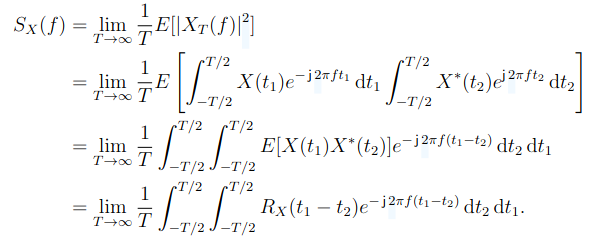

In [12]:
imgs[0]

In [13]:
feature_extractor.do_convert_rgb = True

In [14]:
tensor = feature_extractor(imgs[0], return_tensors="pt").pixel_values

In [15]:
tensor.shape

torch.Size([1, 3, 448, 448])

In [46]:
from transformers.generation.utils import GenerationConfig

In [51]:
generation_config = GenerationConfig.from_model_config(model.config)

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 30000,
  "max_length": 512,
  "pad_token_id": 1
}



In [53]:
generation_config.num_beams = 5

In [55]:
output = model.generate(tensor, generation_config=generation_config)[0]

NotImplementedError: Make sure that a `_reorder_cache` function is correctly implemented in transformers.models.gpt2.modeling_gpt2 to enable beam search for <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>

In [38]:
res = tokenizer.decode(output, skip_special_tokens=True)

In [39]:
res = res.replace("\\[", "\\begin{align*}").replace("\\]", "\\end{align*}")

In [41]:
print(res)

\begin{align*}
S_X(f) &= \lim_{T \to \infty} \frac{1}{T} E[ |X_T(f)|^2] \\
&= \lim_{T \to \infty} \frac{1}{T} E \left[ \int_{-T/2}^{T/2} X(t_1) e^{-j 2 \pi f t_1} \, dt_1 \int_{-T/2}^{T/2} X^*(t_2) e^{j 2 \pi f t_2} \, dt_2 \right] \\
&= \lim_{T \to \infty} \frac{1}{T} \int_{-T/2}^{T/2} \int_{-T/2}^{T/2} E[X(t_1) X^*(t_2)] e^{-j 2 \pi f(t_1 - t_2)} \, dt_2 \, dt_1 \\
&= \lim_{T \to \infty} \frac{1}{T} \int_{-T/2}^{T/2} \int_{-T/2}^{T/2} R_X(t_1 -


In [29]:
output.shape

torch.Size([1, 257])

In [28]:
res

'<s><s>\\[\nS_X(f) &= \\lim_{T \\to \\infty} \\frac{1}{T} E[ |X_T(f)|^2] \\\\\n&= \\lim_{T \\to \\infty} \\frac{1}{T} E \\left[ \\int_{-T/2}^{T/2} X(t_1) e^{-j 2 \\pi f t_1} \\, dt_1 \\int_{-T/2}^{T/2} X^*(t_2) e^{j 2 \\pi f t_2} \\, dt_2 \\right] \\\\\n&= \\lim_{T \\to \\infty} \\frac{1}{T} \\int_{-T/2}^{T/2} \\int_{-T/2}^{T/2} E[X(t_1) X^*(t_2)] e^{-j 2 \\pi f(t_1 - t_2)} \\, dt_2 \\, dt_1 \\\\\n&= \\lim_{T \\to \\infty} \\frac{1}{T} \\int_{-T/2}^{T/2} \\int_{-T/2}^{T/2} R_X(t_1 -</s>'

In [42]:
tokens = tokenizer.batch_decode(output, skip_special_tokens=True)

In [46]:
output[1]

tensor([    0,     0,    64,   575,    95,  4086,  1533,   358,    80,  5068,
           97,   203,    64,   809,   203,    64,   570,    95, 12277,  2363,
           97,   290,   262,   570,    95, 17676,    97,   290,   262,   570,
           95,    51, 10674,    97,   290,   262,   570,    95,    47,  1920,
           97,   290,   262,   570,    95, 17658,    97,   290,   262,   570,
           95,    55,    84,   446,    97,   290,   262,   570,    95,    49,
         4063,    97,   290,   262,   570,    95,    56, 23213,    97,   583,
          203,    64,   809,   203,    38,    48,  6927,    17,    22,  2010,
         1410,    65,   290, 10517,    18,    25,   290,  6983,    18,    21,
          290,  6983,    18,    28,   290,  1613,    18,    20,   290,  6681,
           18,    22,   290,  1452,    18,    28,   290, 10016,    18,    24,
          583,   203,    48,  1543,    58,    37,    17,    27,    38,  2010,
         1559,    65,   290,  9803,    18,    20,   290,  7705, 

In [56]:
model.config

VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "gpt2_base",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "initializer_range": 0.02,
    "is_decoder": true,
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 6,
    "n_positions": 516,
    "reorder_and_upcast_attn": false,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "summary_proj_to_labels": true,
    "summary_type": "cls_index",
    "summary_use_proj": true,
    "torch_dtype": "float32",
    "type_vocab_size": 1,
    "use_cache": true,
    "vocab_size": 30002
  },
  "decoder_start_token_id": 0,
  "encoder": {
    "_name_or_path"

In [45]:
tokens[1]

'\\begin{tabular}{lcccc}\n\\hline\n\\textbf{Method} & \\textbf{Rec} & \\textbf{OCR} & \\textbf{Know} & \\textbf{Gen} & \\textbf{Spat} & \\textbf{Math} & \\textbf{Total} \\\\\n\\hline\nBLIP-2 [19] & 27.5 & 11.1 & 11.8 & 7.0 & 16.2 & 5.8 & 22.4 \\\\\nLLaVA-7B [25] & 28.0 & 17.1 & 16.3 & 18.9 & 21.2 & 11.5 & 23.8 \\\\\nMiniGPT-4 [5] & 29.9 & 16.1 & 20.4 & 22.1 & 22.2 & 3.8 & 24.4 \\\\\nOtter [18] & 27.3 & 17.8 & 14.2 & 13.8 & 24.4 & 3.8 & 24.7 \\\\\nOpenFlamingo [1] & 28.7 & 16.7 & 16.4 & 13.1 & 21.0 & 7.7 & 24.8 \\\\\nLLaVA-1B [25] & 39.2 & 22.7 & 26.5 & 29.3 & 29.6 & 7.7 & 32.9 \\\\\nLLaVA1.5-7B [24] & - & - & - & - & - & 30.5 \\\\\n\\hline\nVary-base (viconn7B) (6651) & 38.7 & 22.0 & 23.6 & 24.1 & 29.6 & 7.7 & 32.9 \\\\\nVary-base (qwen7B) (80k) & 38.9 & \\underline{30.1} & 22.4 & 21.7 & \\underline{34.3} & 7.7 & \\underline{36.2} \\\\\nTable 3: Comparison with popular methods on MMVet. The abbreviations represent: Rec: Recognition: Know: Knowledge, Gen: Language generation, Spat Spati

In [35]:
tokenizer.convert_ids_to_tokens(output[0].tolist())

['<s>',
 '<s>',
 '\\',
 'textbf',
 '{',
 '12',
 '34',
 'bar',
 'j',
 'ak',
 'se',
 'w',
 'l',
 'w',
 'm',
 'z',
 'ov',
 's',
 'el',
 'w',
 'ic',
 '}',
 'lim',
 '(',
 'z',
 ')',
 '</s>']

In [25]:
tokens

['\\textbf{1234barjaksewlwmzovselwic}lim(z)']

In [44]:
model.generate()

VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "gpt2_base",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "initializer_range": 0.02,
    "is_decoder": true,
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 6,
    "n_positions": 516,
    "reorder_and_upcast_attn": false,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "summary_proj_to_labels": true,
    "summary_type": "cls_index",
    "summary_use_proj": true,
    "torch_dtype": "float32",
    "type_vocab_size": 1,
    "use_cache": true,
    "vocab_size": 30002
  },
  "decoder_start_token_id": 0,
  "encoder": {
    "_name_or_path"

In [ ]:
a = 

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 30000,
  "max_length": 512,
  "pad_token_id": 1
}

